# 日経平均株価

In [6]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import yfinance as yf

## 日経平均株価の yf.Ticker インスタンスの作成

In [7]:
symbol = '^N225'
ticker = yf.Ticker(symbol)

## 過去半年の日足データ

In [8]:
df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-06 00:00:00+09:00,39792.371094,40147.769531,39769.039062,40090.781250,112900000,0.0,0.0
2024-03-07 00:00:00+09:00,40331.058594,40472.109375,39518.398438,39598.710938,137200000,0.0,0.0
2024-03-08 00:00:00+09:00,39809.558594,39989.328125,39551.601562,39688.941406,143300000,0.0,0.0
2024-03-11 00:00:00+09:00,39232.140625,39241.281250,38496.660156,38820.488281,132900000,0.0,0.0
2024-03-12 00:00:00+09:00,38470.390625,38841.800781,38271.378906,38797.511719,112900000,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-02 00:00:00+09:00,39025.308594,39080.640625,38476.511719,38700.871094,87100000,0.0,0.0
2024-09-03 00:00:00+09:00,38745.761719,38967.558594,38581.550781,38686.308594,91200000,0.0,0.0
2024-09-04 00:00:00+09:00,38039.910156,38080.019531,36879.328125,37047.609375,144400000,0.0,0.0


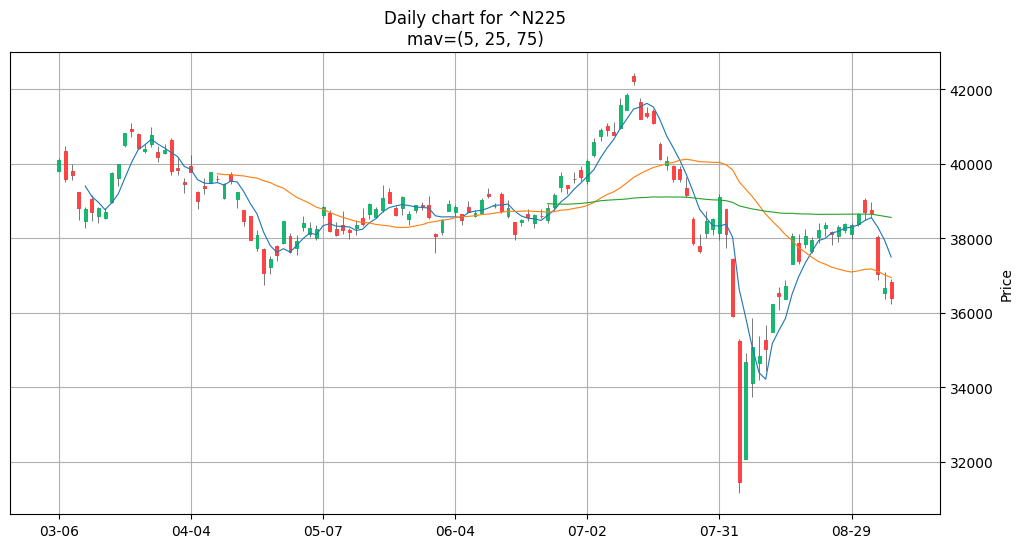

In [17]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

mpf.plot(
    df,
    type='candle',
    style='yahoo',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.savefig('daily_chart.png')
plt.show()